# Stage 2: Latent time predicted by scLTNN (CD8+Tcell)
Here, you will be briefly guided through the basics of how to use scLTNN. Once you are set, the following tutorials go straight into analysis of latent time by raw count of scRNA-seq.
In the CD8+Tcell dataset, we can get the similiar result without any input。


In [ ]:
# update to the latest version, if not done yet.
!pip install scltnn --upgrade --quiet

In [1]:
import scltnn
import scanpy as sc
import scvelo as scv
import anndata
import matplotlib.pyplot as plt
import leidenalg

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.2 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.2 pynndescent==0.5.8


## Loading the data
The analysis is based on the data of CD8+Tcell of B-cell lymphoma.

In [3]:
adata = scltnn.datasets.Cancer_CD8()
adata

......Loading dataset from datasets/ZhangZemin_CD8+.h5ad


AnnData object with n_obs × n_vars = 3482 × 28855
    obs: 'cellID', 'cancerType', 'patient', 'libraryID', 'loc', 'meta.cluster', 'platform'

## Preprocess the Data
Preprocessing requisites consist of cell selection by detection (with a minimum and maximum number of counts), gene selection by detection (with a minimum number of counts) and high variability (top 10,000 genes), normalizing every cell by its total size and logarithmizing X.Calculating the UMAP position of datasets

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata = adata[adata.obs.n_genes_by_counts < 4000, :] #the number of n_genes_by_counts threshold is based on the datasets
adata = adata[adata.obs.pct_counts_mt < 10, :]

sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata

filtered out 13866 genes that are detected in less than 3 cells
computing PCA
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


AnnData object with n_obs × n_vars = 3450 × 14989
    obs: 'cellID', 'cancerType', 'patient', 'libraryID', 'loc', 'meta.cluster', 'platform', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [5]:
CD8=scltnn.models.scLTNN(adata)

In [6]:
CD8.cal_high_variable_genes(10000)

......calculate high_variable_genes 10000
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


## Calculate the latent semantic index (lsi)
We need to calculate the lsi of scRNA-seq and thus obtain the potential timing topics for each cell

In [7]:
CD8.cal_lsi(n_components=100)

......calculate lsi


## Calculate the PAGA
For simple, coarse-grained visualization, compute the PAGA graph, a coarse-grained and simplified (abstracted) graph. Non-significant edges in the coarse- grained graph are thresholded away. But in scLTNN, you only need to use scLTNN.cal_page to complete this calculation.

In [8]:
CD8.cal_paga(resolution=1.0)

......calculate paga
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


## Calculate the pre-model time
We have computed some single-cell latent times in advance by scVelo and trained an artificial neural network (ANN) model with these latent times. We can use these known models to initially determine the starting and ending points of the evolution of our single-cell atlas.

In [9]:
model_path=scltnn.models.LTNN_model_pre('ANN_LSI_100')
CD8.load_model(model_path)

......Loading dataset from datasets/ANN_LSI_100.h5
Metal device set to: Apple M1 Pro


2023-01-18 01:01:09.191630: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-18 01:01:09.191738: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
CD8.cal_model_time()

......predict model_time


2023-01-18 01:01:09.403607: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 60/108 [===============>..............] - ETA: 0s

2023-01-18 01:01:09.445084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


108/108 [==============================] - 0s 2ms/step


## Calculate the expression-related gene value

Sometimes, the starting point and the end point determined by our model are just opposite, in order to avoid this situation, we calculate the mean value of expression-related gene for quantitative analysis. As stem cells become more differentiated and more like adult cells, they express fewer and fewer genes. Here, we determine the node with high expression-related gene as the starting node and the node with low expression-related gene as the end node.


In [11]:
CD8.cal_exp_gene_value()
CD8.cal_dpt_pseudotime(leiden_range_end=0.02)

filtered out 115 genes that are detected in less than 3 cells
gene in p_time_low 4.227893 gene in p_time_high 5.427857
......calculate dpt_pseudotime
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9914892  0.9806591  0.9708176  0.9670417  0.95854396
     0.95290416 0.9450066  0.93842286 0.93673396 0.9301132  0.927287
     0.92258537 0.9192446  0.9153877 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)
......leiden_start: ['12']
......leiden_middle ['1', '3']
......leiden_end ['6', '15']


## Trainning the ANN model
We select the newly determined starting point and the end point, construct a normal distribution with mean 0.03 and 0.97 for the starting point and end point respectively, and then use the starting point and end point regression ANN model to predict the time series data of all cells

In [12]:
CD8.ANN(batch_size=30,epochs=50,verbose=0)

......ANN
Model: "scLTNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 577,537
Trainable params: 577,537
Non-trainable params: 0
_________________________________________________________________
None


2023-01-18 01:01:11.700441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-18 01:01:12.071427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


......ANN:loss 0.02643074281513691 MAE 0.12869474291801453
......predicted ANN Time
 91/108 [========================>.....] - ETA: 0s

2023-01-18 01:01:22.409362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


108/108 [==============================] - 0s 2ms/step


## Calculate the distribution of PAGA graph and ANN model
We use 10 common distributions to fit the distribution to the diffusion pseudotime of the PAGA graph and the time of the ANN model regression, respectively.

Note (In general, the distribution obtained from the PAGA graph is dweibull and the distribution obtained from the ANN model is norm)

In [13]:
CD8.cal_distrubute()

......Dweibull analysis
[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 19.9943] [loc=0.646 scale=0.249]
[distfit] >[expon     ] [0.00 sec] [RSS: 50.8278] [loc=0.000 scale=0.646]
[distfit] >[pareto    ] [0.00 sec] [RSS: 50.8278] [loc=-67108864.000 scale=67108864.000]
[distfit] >[dweibull  ] [0.01 sec] [RSS: 21.1199] [loc=0.632 scale=0.229]
[distfit] >[t         ] [0.12 sec] [RSS: 19.9939] [loc=0.646 scale=0.249]
[distfit] >[genextreme] [0.03 sec] [RSS: 11.5552] [loc=0.611 scale=0.275]
[distfit] >[gamma     ] [0.03 sec] [RSS: 20.6733] [loc=-3.118 scale=0.017]
[distfit] >[lognorm   ] [0.07 sec] [RSS: 20.1199] [loc=-95.540 scale=96.185]
[distfit] >[beta      ] [0.02 sec] [RSS: 11.534] [loc=-0.116 scale=1.116]
[distfit] >[uniform   ] [0.00 sec] [RSS: 25.5892] [loc=0.000 scale=1.000]
[distfit] >[loggamma  ] [0.00 sec] [RSS: 10.0815] [loc=0.969 scale=0.018]
[distfit] >Compute confidence interval [parametric]
......Norm analysis
[distfit] >fit..
[distfit] >tra

## Calculate the LTNN time
In this step, we combine the results of the PAGA graph with the ANN model, reinforcing the intermediate values of the PAGA graph (using the ANN model normal distribution as a parameter) and reinforcing the two end values of the ANN model (using the dweibull distribution of the PAGA grapha as a parameter).

In [14]:
CD8.cal_scLTNN_time()


......calculate scLTNN time


## Visualization
We can compare the real differentiation stage of CD8+ Tcell and the LTNN time, and thus confirm that our predicted latent time is reliable

--> added 'pos', the PAGA positions (adata.uns['paga'])


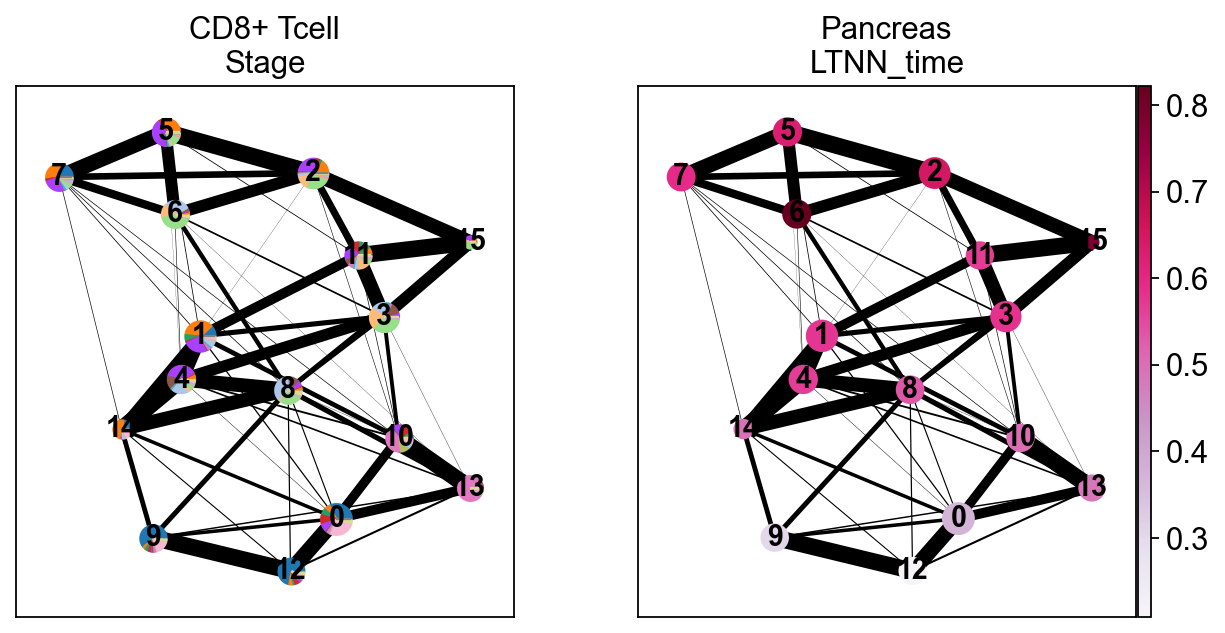

In [15]:
sc.pl.paga(CD8.adata_test, color=['meta.cluster','LTNN_time'],cmap='PuRd',
          title=['CD8+ Tcell\nStage','Pancreas\nLTNN_time'],)
          #save='_fig3_CD8+Tcell.png')

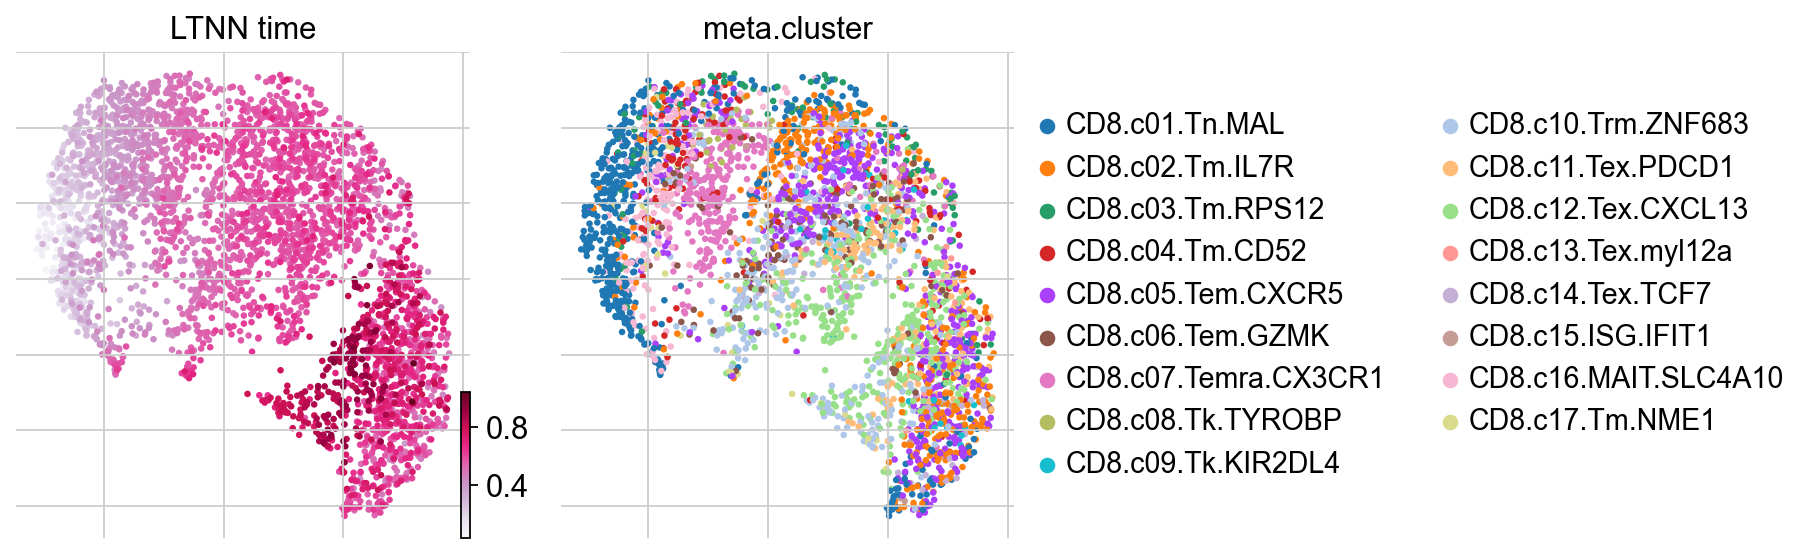

In [16]:
scv.pl.scatter(CD8.adata_test, basis="umap",color=['LTNN_time','meta.cluster'],
               cmap='PuRd',legend_loc='right margin')
               #save='_fig4_CD8+Tcell.png')

## Find the related-gene of LTNN_time
A easy function scltnn.utils.find_high_correlation_gene we provide to find out the LTNN-time related genes
Besides,we also provide another easy function scltnn.plot.plot_high_correlation_heatmap to visualize the gene and time

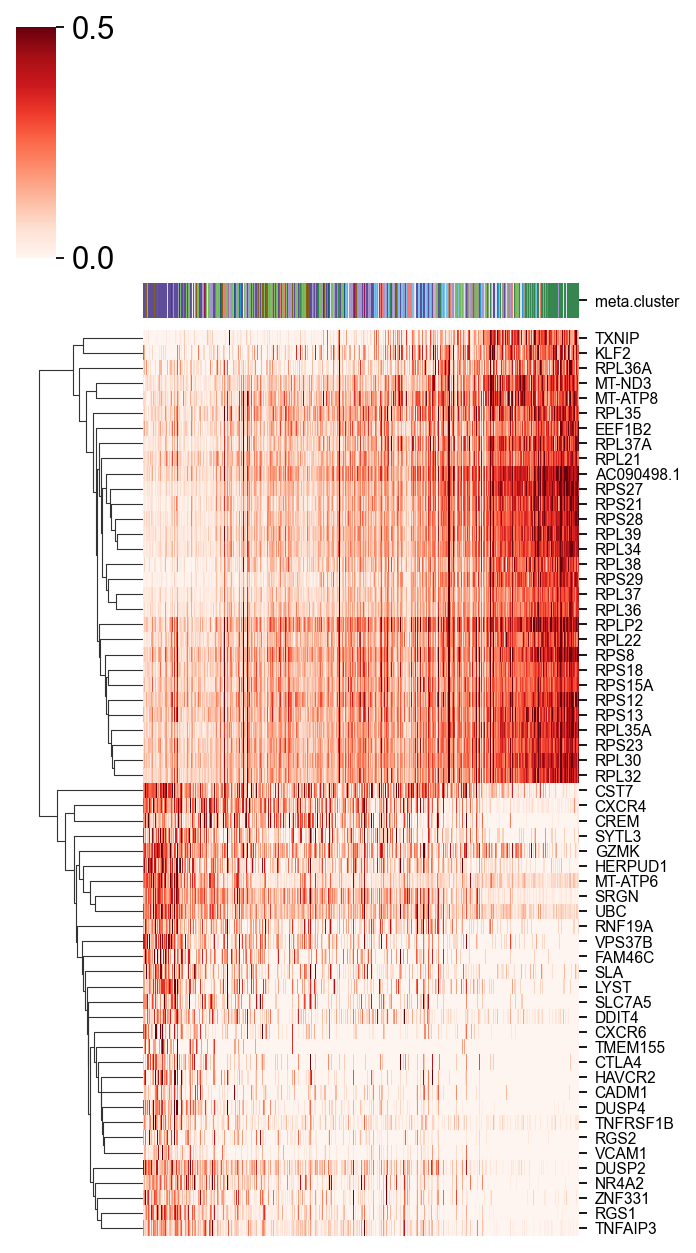

In [17]:
import seaborn as sns
LTNN_time_Pearson,adata_1=scltnn.utils.find_high_correlation_gene(CD8.adata_test,rev=True)
scltnn.plot.plot_high_correlation_heatmap(adata_1,LTNN_time_Pearson,fontsize=7,standard_scale=0,
                              meta=['meta.cluster'],figsize=(5,8),number=30,cmap='Reds',
                             meta_legend=True,meta_legend_kws={'ncol':1,'distance':20,'interval':3})
#plt.savefig('heatmap_CD8.png',dpi=300,bbox_inches = 'tight')

## Visualize the origin and Tesmination cell
A easy function scltnn.plot.plot_origin_tesmination we provide to visualize the origin and tesmination cell clusters

<AxesSubplot: title={'center': 'Origin and Tesmination'}, xlabel='UMAP1', ylabel='UMAP2'>

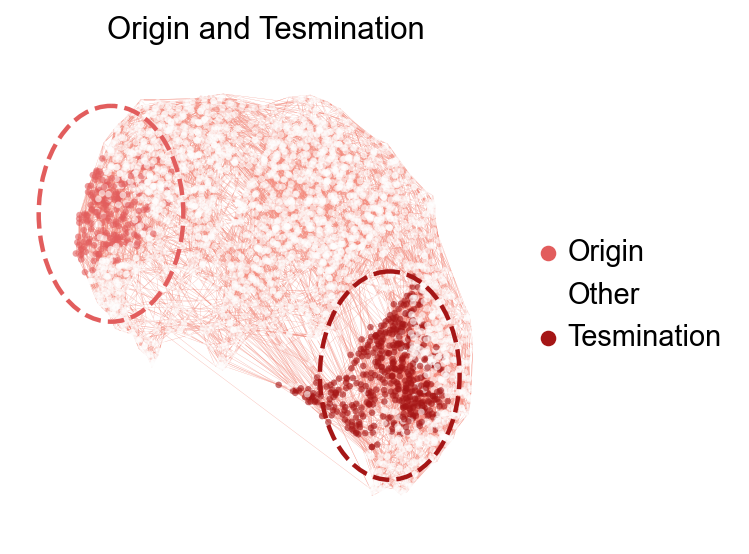

In [18]:
#sc.tl.umap(scpancera.adata_test)
scltnn.plot.plot_origin_tesmination(CD8.adata_test,origin=['12'],tesmination=['6','5'])

## Visualize the trajectory by LTNN time

To get some intuition for this transition matrix, we can project it into an embedding and draw the same sort of arrows that we all got used to from RNA velocity - the following plot will look exactly like the plots you’re used to from scVelo for visualizing RNA velocity, however, there’s no RNA velocity here (feel free to inspect the AnnData object closely), we’re visualizing the directed transition matrix we computed using the KNN graph as well as the LTNN pseudotime.

In [19]:
ptk = scltnn.PseudotimeKernel(CD8.adata_test,time_key='LTNN_time')
ptk

PseudotimeKernel[n=3450]

In [20]:
ptk.compute_transition_matrix()
ptk.compute_projection(basis='umap')

100%|████████████████████████████████████████████████████████████████████████████████████████████| 3450/3450 [00:00<00:00, 7794.41cell/s]


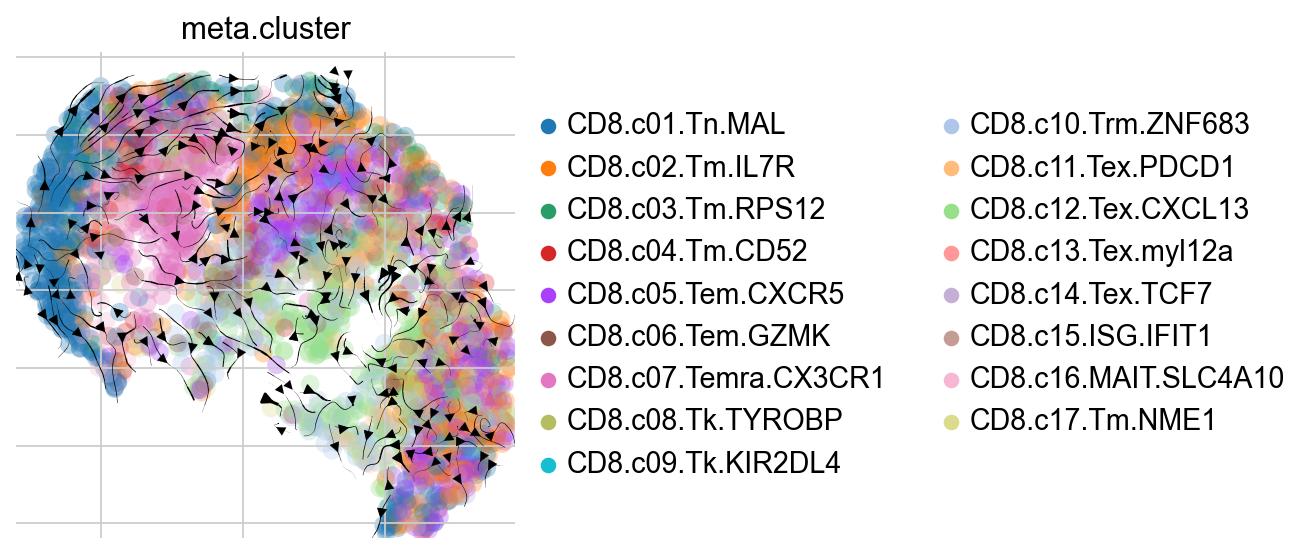

In [21]:
scv.pl.velocity_embedding_stream(CD8.adata_test,vkey='T_fwd', basis='umap',
                                color='meta.cluster',legend_loc='right margin')